In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from lammps_implicit_der.tools import plot_tools, error_tools
from tqdm import tqdm

In [2]:
def safe_load_pkl(file):
    if os.path.exists(file):
        with open(file, 'rb') as f:
            data = pickle.load(f)
        return data
    else:
        print(f'File {file} does not exist')
        return None

In [24]:
delta = 0.001
#num_cells = 8
num_cells = 12
#method = 'inverse'
#method = 'energy'

#path = '.'
path='/Users/imaliyov/run/potential-perturbation/HEA-one-shot/NERSC/compare_methods'

#filename = f'HEA_NiMo_{method}_{delta:.4f}_{num_cells:03d}.pkl'

filename_energy = f'HEA_NiMo_energy_{delta:.4f}_{num_cells:03d}.pkl'
filename_inverse = f'HEA_NiMo_inverse_{delta:.4f}_{num_cells:03d}.pkl'
filename_sparse = f'HEA_NiMo_sparse_{delta:.4f}_{num_cells:03d}.pkl'

output_dict_inverse = safe_load_pkl(os.path.join(path, f'HEA_NiMo_inverse_{delta:.4f}_{num_cells:03d}.pkl'))
output_dict_energy = safe_load_pkl(os.path.join(path, f'HEA_NiMo_energy_{delta:.4f}_{num_cells:03d}.pkl'))
output_dict_sparse = safe_load_pkl(os.path.join(path, f'HEA_NiMo_sparse_{delta:.4f}_{num_cells:03d}.pkl'))

In [25]:

# Unpack the output_dict_energy
delta = output_dict_energy['delta']
dTheta = output_dict_energy['dTheta']
Theta_Ni = output_dict_energy['Theta_Ni']
Theta_Mo = output_dict_energy['Theta_Mo']
Theta_Mo_pert = output_dict_energy['Theta_Mo_pert']
dX_dTheta = output_dict_energy['dX_dTheta']
dX_pred = output_dict_energy['dX_pred']
dX_true = output_dict_energy['dX_true']
X_pred = output_dict_energy['X_pred']
X_true = output_dict_energy['X_true']
Natom = output_dict_energy['Natom']
dX_dTheta = output_dict_energy['dX_dTheta']
method = output_dict_energy['method']
species = output_dict_energy['species']
X0 = output_dict_energy['X0']

In [26]:
print(output_dict_sparse['timings_system']['total']['runtime'])
print(output_dict_energy['timings_system']['total']['runtime'])
print(output_dict_inverse['timings_system']['total']['runtime'])

9844.73813656
184.57151793
964.35362802


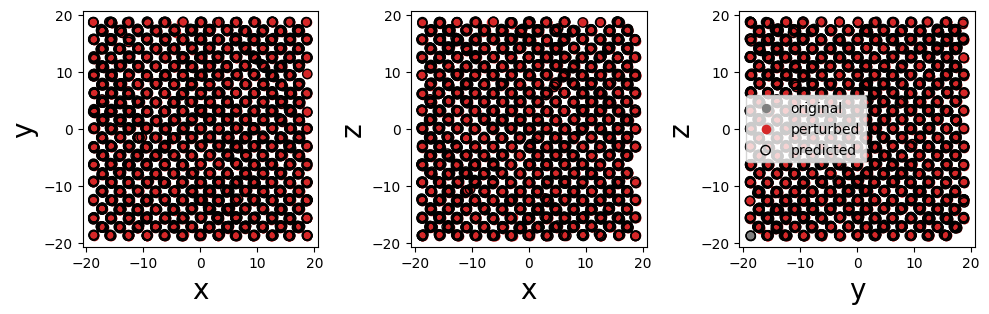

In [27]:
# Plot the coordinates
specie_color = {1: 'tab:orange', 2: 'tab:blue'}
specie_colors = [specie_color[s] for s in species]

color_list = ['black','tab:orange', 'tab:blue', 'black']
label_list = ['original', 'Ni', '$\delta$Mo', 'from dX/dTheta']

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

plot_tools.plot_coords(axes, X0.reshape(-1, 3), c='gray', s=32, label='original')
plot_tools.plot_coords(axes, X_true.reshape(-1, 3), c='tab:red', s=35, label='perturbed')
plot_tools.plot_coords(axes, X_pred.reshape(-1, 3), s=45, label='predicted', facecolors='none', edgecolors='black', marker='o')
plt.tight_layout()
plt.show()

In [7]:
error_tools.coord_error(X_true, X_pred)

2.7211178618709358e-06

energy
inverse
sparse


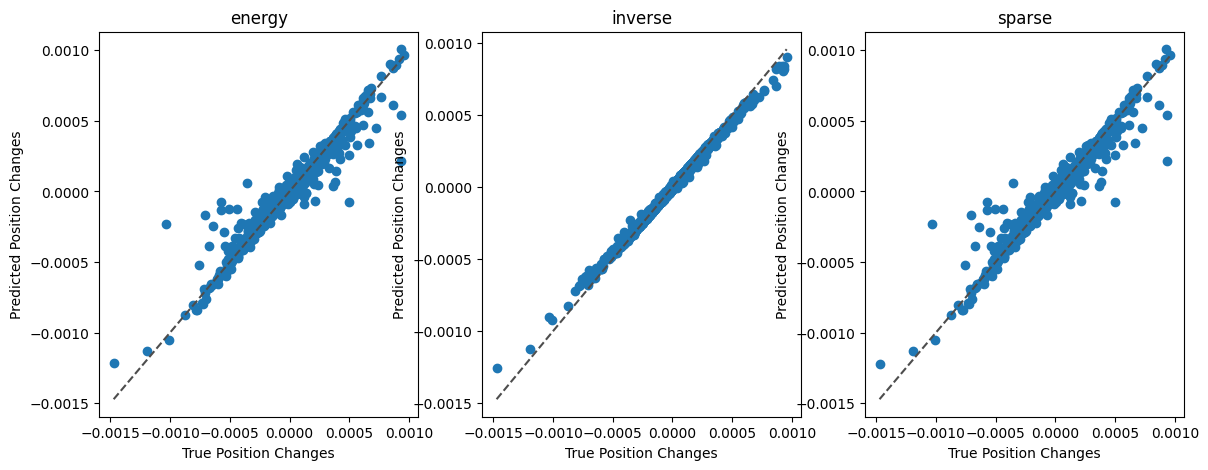

In [8]:
# Plot dX_true vs dX_pred

#fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

# energy and inverse
#for i, output_dict in enumerate([output_dict_energy, output_dict_inverse]):
for i, output_dict in enumerate([output_dict_energy, output_dict_inverse, output_dict_sparse]):

    dX_true = output_dict['dX_true']
    dX_pred = output_dict['dX_pred']
    method = output_dict['method']
    ax[i].plot(dX_true, dX_pred, 'o')
    print(method)

    ax[i].set_xlabel('True Position Changes')
    ax[i].set_ylabel('Predicted Position Changes')

    # plot y=x line
    ax[i].plot( [dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], ls="--", c=".3")
    ax[i].set_title(f'{method}')

plt.show()

(10368,)
(10368,)


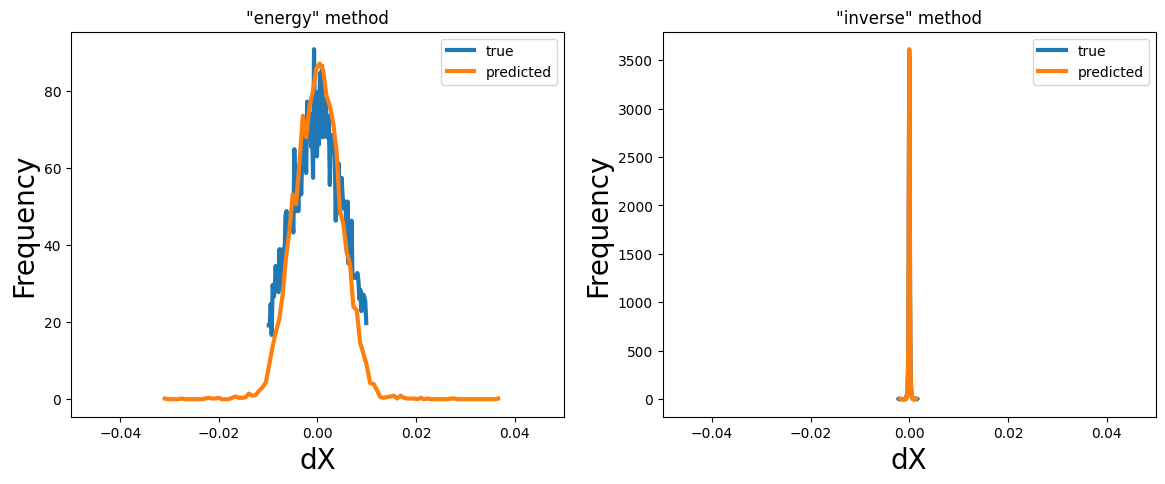

In [23]:
# plot histogram dX_pred vs dX_true

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for i, output_dict in enumerate([output_dict_energy, output_dict_inverse]):

    dX_true = output_dict['dX_true']
    dX_pred = output_dict['dX_pred']
    method = output_dict['method']

    xmin, xmax = -0.01, 0.01
    dX_true_plot = dX_true[(dX_true > xmin) & (dX_true < xmax)]
    dX_pred_plot = dX_pred[(dX_true > xmin) & (dX_true < xmax)]

    #dX_true_plot = dX_true
    #dX_pred_plot = dX_pred

    #ax[i].hist(dX_true_plot, bins=100, color='tab:blue', alpha=0.5, label='true')
    #ax[i].hist(dX_pred_plot, bins=100, color='tab:orange', alpha=0.5, label='predicted')

    # Transform hists to curves
    hist, bin_edges = np.histogram(dX_true_plot, bins=100, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax[i].plot(bin_centers, hist, label='true', color='tab:blue', lw=3)

    hist, bin_edges = np.histogram(dX_pred_plot, bins=100, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax[i].plot(bin_centers, hist, label='predicted', color='tab:orange', lw=3)

    fsize=20
    ax[i].set_xlabel('dX', fontsize=fsize)
    ax[i].set_ylabel('Frequency', fontsize=fsize)
    ax[i].legend()
    ax[i].set_title(f'"{method}" method')

    ax[i].set_xlim(-0.05, 0.05)

print(dX_true.shape)
print(dX_pred.shape)

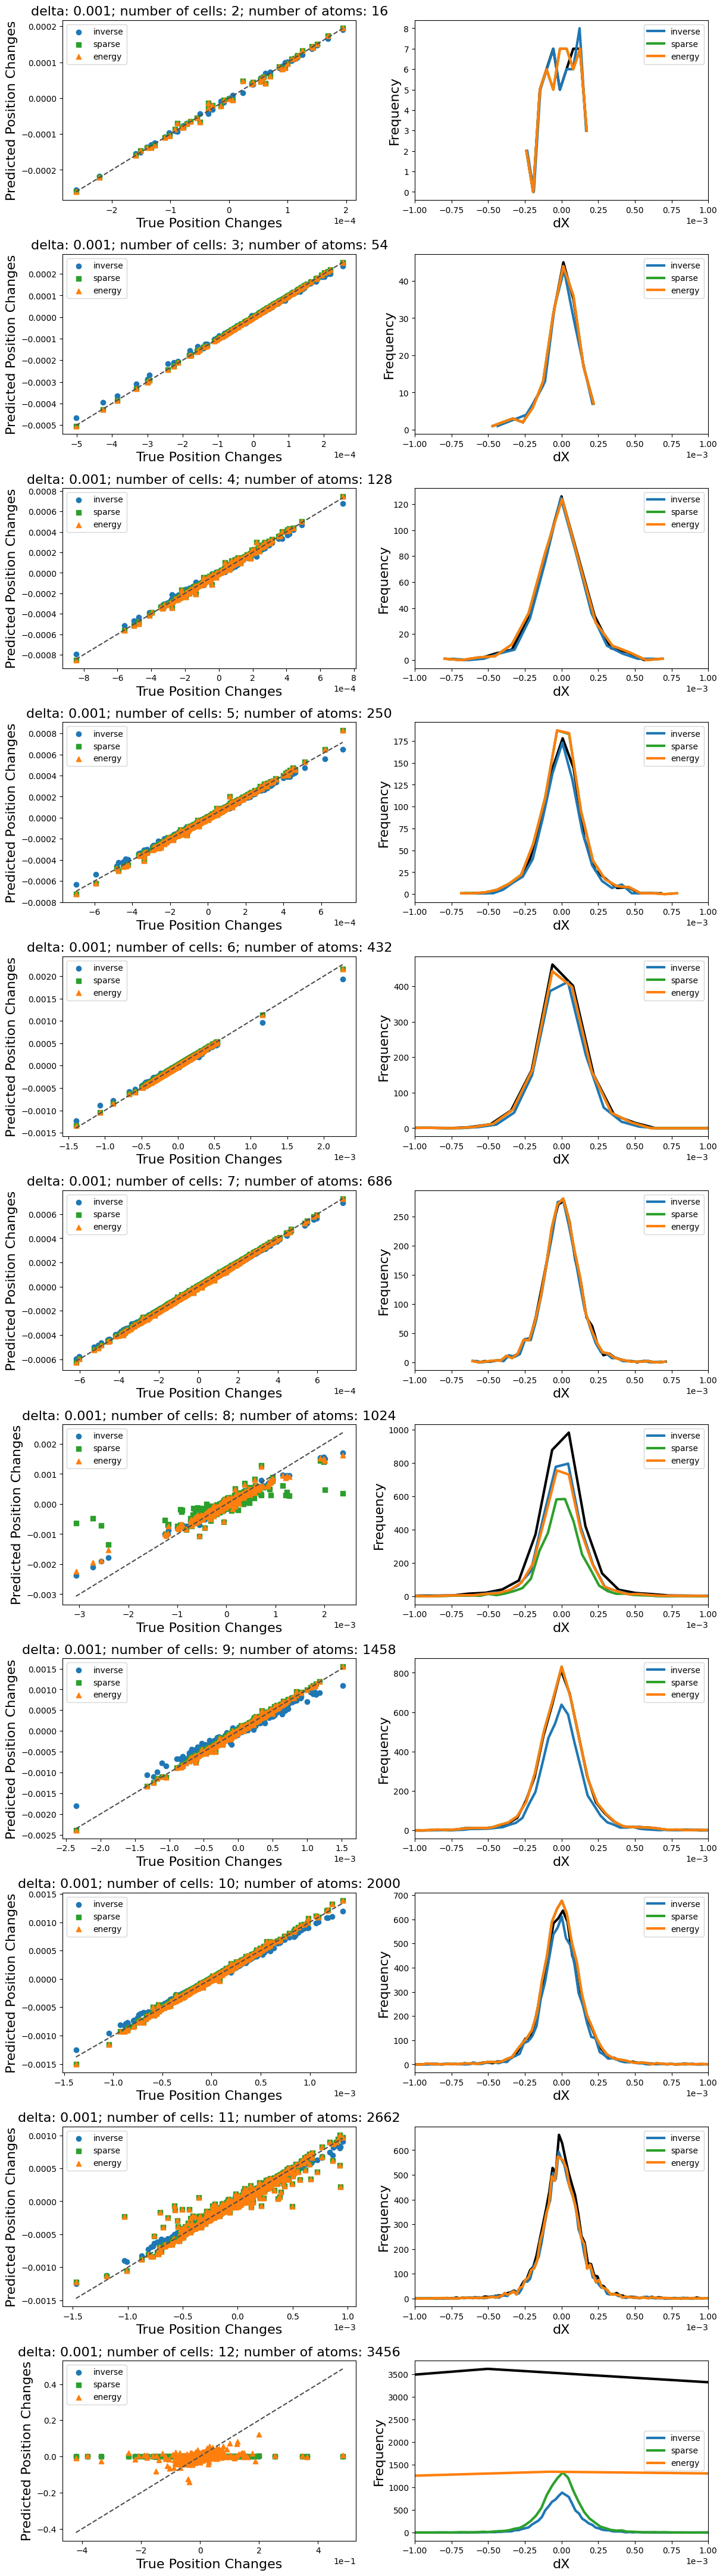

In [57]:
num_cells_min = 2
num_cells_max = 12

# Create the subplot structure
fig, ax = plt.subplots(num_cells_max - num_cells_min + 1, 2, figsize=(14, 5 * (num_cells_max - num_cells_min + 1)))
plt.subplots_adjust(hspace=0.3)

def get_bins(natom, bin_min=10, bin_max=200, natom_min=5, natom_max=5000):
    # Linear scaling of bins based on the number of atoms
    return int(bin_min + (bin_max - bin_min) * (natom - natom_min) / (natom_max - natom_min))


# Define a function to plot histograms to avoid repetitive code
def plot_histogram(data, ax, natom, bin_min=10, bin_max=200, **kwargs):
    bins = get_bins(natom, bin_min=10, bin_max=200, natom_min=5, natom_max=5000)
    hist, bin_edges = np.histogram(data, bins=bins, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, hist, **kwargs)

color_list = ['tab:blue', 'tab:green', 'tab:orange']
marker_list = ['o', 's', '^']
method_list = ['inverse', 'sparse', 'energy']

for i, num_cells in enumerate(range(num_cells_min, num_cells_max + 1)):
    results = {}
    for method in method_list:
        results[method] = safe_load_pkl(os.path.join(path, f'HEA_NiMo_{method}_{delta:.4f}_{num_cells:03d}.pkl'))

    natom = results['energy']['Natom']
    dX_true = results['energy']['dX_true']

    plot_histogram(dX_true, ax[i, 1], natom, color='black', lw=3)
    for j, method in enumerate(method_list):
        dX_pred = results[method]['dX_pred']
        ax[i, 0].scatter(dX_true, dX_pred, label=method, marker=marker_list[j], color=color_list[j])
        plot_histogram(dX_pred, ax[i, 1], natom, label=method, color=color_list[j], lw=3)

    ax[i, 0].plot([dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], ls="--", c=".3")
    ax[i, 0].set_xlabel('True Position Changes', fontsize=fsize)
    ax[i, 0].set_ylabel('Predicted Position Changes', fontsize=fsize)
    ax[i, 0].set_title(f'delta: {delta}; number of cells: {num_cells}; number of atoms: {natom}', fontsize=fsize)
    ax[i, 0].legend()

    fsize = 16
    ax[i, 1].set_xlabel('dX', fontsize=fsize)
    ax[i, 1].set_ylabel('Frequency', fontsize=fsize)
    ax[i, 1].set_xlim(-0.001, 0.001)

    # Change the format of the x-axis to scientific notation
    for j in range(2):
        ax[i, j].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    ax[i, 1].legend()

plt.show()

{'energy': {'num_cells': 10, 'Natom': 2000, 'delta': 0.001, 'dTheta': array([ 6.08956217e-07, -3.07468804e-05,  3.30036801e-05, -6.64556350e-05,
       -4.01627798e-05,  8.66536736e-06, -2.61364837e-05,  2.10909489e-05,
        6.27141155e-05,  1.13120064e-04,  4.24109640e-05, -6.58280907e-05,
       -3.96474881e-05, -8.20752333e-07,  6.04056832e-05, -3.67107543e-05,
       -9.08090609e-06, -4.03392348e-05, -5.92304546e-05,  2.01275547e-05,
        5.60440765e-08, -6.10309692e-06,  1.24493284e-05, -4.35995779e-05,
       -2.19749867e-06, -8.09397605e-06,  3.96938536e-06, -1.99599568e-05,
       -1.07491160e-05,  9.67975896e-06]), 'method': 'energy', 'dX_dTheta': array([[ 2.72446374e+00,  8.69448235e+00, -1.25476154e-01, ...,
         2.57404400e-01, -3.31875262e-01,  7.73410527e+00],
       [-4.50515105e-01,  2.27640338e-01, -4.84065293e-01, ...,
        -2.59455710e-01, -2.82850030e-01,  2.51964193e-01],
       [ 6.29933259e-02, -8.54398285e-02,  9.74330057e-02, ...,
        -2.283893

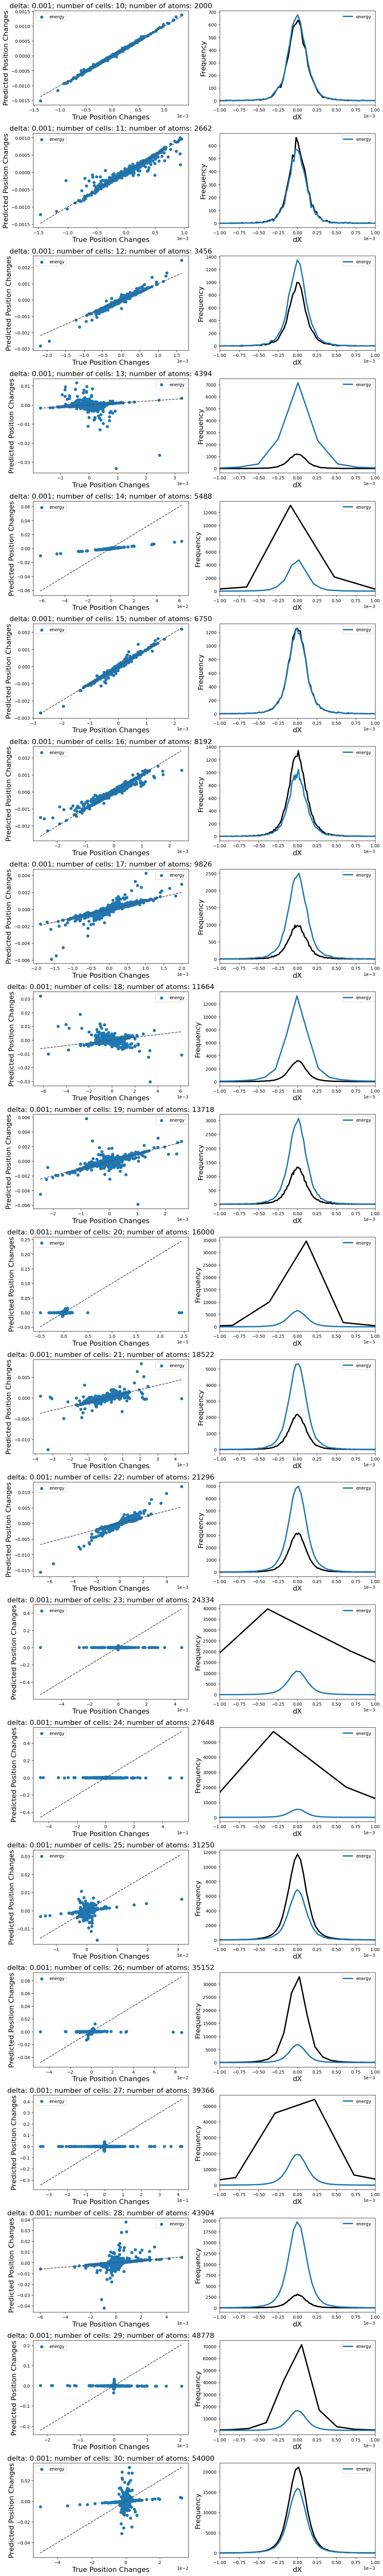

In [59]:
num_cells_min = 10
num_cells_max = 30

# Create the subplot structure
fig, ax = plt.subplots(num_cells_max - num_cells_min + 1, 2, figsize=(14, 5 * (num_cells_max - num_cells_min + 1)))
plt.subplots_adjust(hspace=0.3)

def get_bins(natom, bin_min=10, bin_max=200, natom_min=5, natom_max=5000):
    # Linear scaling of bins based on the number of atoms
    return int(bin_min + (bin_max - bin_min) * (natom - natom_min) / (natom_max - natom_min))


# Define a function to plot histograms to avoid repetitive code
def plot_histogram(data, ax, natom, bin_min=10, bin_max=200, **kwargs):
    bins = get_bins(natom, bin_min=10, bin_max=200, natom_min=5, natom_max=5000)
    hist, bin_edges = np.histogram(data, bins=bins, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, hist, **kwargs)

color_list = ['tab:blue', 'tab:green', 'tab:orange']
marker_list = ['o', 's', '^']
method_list = ['energy']

delta = 0.001
path_big='/Users/imaliyov/run/potential-perturbation/HEA-one-shot/NERSC/energy_big'
for i, num_cells in enumerate(range(num_cells_min, num_cells_max + 1)):
    results = {}
    for method in method_list:
        results[method] = safe_load_pkl(os.path.join(path_big, f'HEA_NiMo_{method}_{delta:.4f}_{num_cells:03d}.pkl'))

    natom = results['energy']['Natom']
    dX_true = results['energy']['dX_true']

    plot_histogram(dX_true, ax[i, 1], natom, color='black', lw=3)
    for j, method in enumerate(method_list):
        dX_pred = results[method]['dX_pred']
        ax[i, 0].scatter(dX_true, dX_pred, label=method, marker=marker_list[j], color=color_list[j])
        plot_histogram(dX_pred, ax[i, 1], natom, label=method, color=color_list[j], lw=3)

    ax[i, 0].plot([dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], ls="--", c=".3")
    ax[i, 0].set_xlabel('True Position Changes', fontsize=fsize)
    ax[i, 0].set_ylabel('Predicted Position Changes', fontsize=fsize)
    ax[i, 0].set_title(f'delta: {delta}; number of cells: {num_cells}; number of atoms: {natom}', fontsize=fsize)
    ax[i, 0].legend()

    fsize = 16
    ax[i, 1].set_xlabel('dX', fontsize=fsize)
    ax[i, 1].set_ylabel('Frequency', fontsize=fsize)
    ax[i, 1].set_xlim(-0.001, 0.001)

    # Change the format of the x-axis to scientific notation
    for j in range(2):
        ax[i, j].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    ax[i, 1].legend()

plt.show()

[0.01270555 0.06352775 0.12705549 0.25411098 0.63527745 1.27055491]


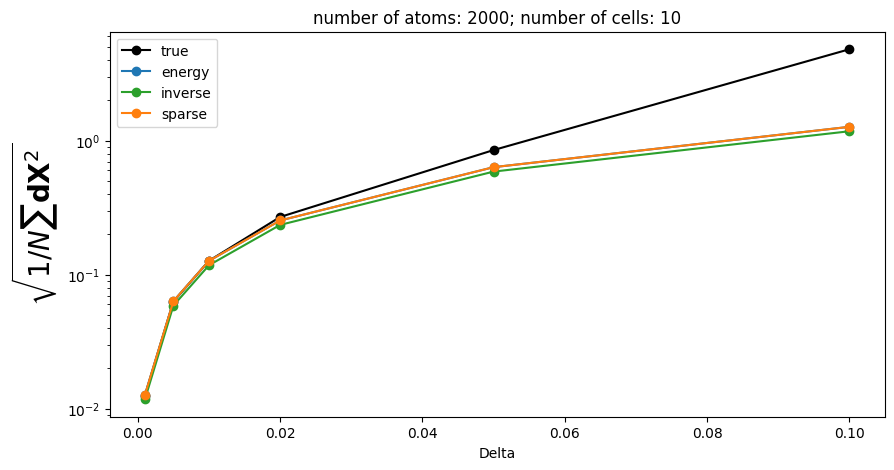

In [107]:
# From the filenames present in the directory, extract possible delta values and sort into array
files = os.listdir(path)
delta_list = np.array([float(f.split('_')[3]) for f in files if 'energy' in f and f.endswith('.pkl')])
delta_list = np.sort(np.unique(delta_list))

num_cells = 10

# Compute X_pred**2 / N for each delta and method

method_list = ['energy', 'inverse', 'sparse']
method_dict = {}

delta_list = delta_list[:6]
for method in method_list + ['true']:
    method_dict[method] = np.zeros(len(delta_list))

for i, delta in enumerate(delta_list):
    for method in method_list:
        output_dict = safe_load_pkl(os.path.join(path, f'HEA_NiMo_{method}_{delta:.4f}_{num_cells:03d}.pkl'))
        dX_pred = output_dict['dX_pred']
        Natom = output_dict['Natom']
        #method_dict[method][i] = np.sqrt(np.sum(dX_pred**2) / Natom)
        method_dict[method][i] = np.linalg.norm(dX_pred)

    dX_true = output_dict['dX_true']
    #method_dict['true'][i] = np.sqrt(np.sum(dX_true**2) / Natom)
    method_dict['true'][i] = np.linalg.norm(dX_true)

print(method_dict['energy'])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

color_list = ['black', 'tab:blue', 'tab:green', 'tab:orange']
for i,method in enumerate(['true']+method_list):
    ax.plot(delta_list, method_dict[method], label=method, marker='o', linestyle='-', color=color_list[i])

ax.set_xlabel('Delta')
ax.set_title(f'number of atoms: {Natom}; number of cells: {num_cells}')

# log y axis
ax.set_yscale('log')
#ax.set_ylabel('(X_pred**2 / N)^{1/2}')
# write same in latex
ax.set_ylabel(r'$\sqrt{1/N \sum \mathbf{dX}^2}$', fontsize=20)
ax.legend()
plt.show()